# 3D Multi-phase Material

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

import jax.numpy as jnp
from jax import Array
import numpy as np

In this example, we solve a linear elasticity problem of a  multiphase material in 3D.

In [2]:
from xpektra import (
    SpectralSpace,
    TensorOperator,
    make_field,
)
from xpektra.scheme import RotatedDifference, Fourier
from xpektra.projection_operator import GalerkinProjection
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient_while,
    newton_krylov_solver,
)

import equinox as eqx


In [3]:
from scipy.spatial.distance import cdist


def generate_multiphase_material_3d(
    size, num_phases=5, num_seeds=None, random_state=None
):
    """
    Generate a 3D multiphase material using Voronoi tessellation.

    Parameters:
    -----------
    size : int or tuple of 3 ints
        Size of the 3D array. If int, creates a cubic array of size (size, size, size).
        If tuple, specifies (nx, ny, nz) dimensions.
    num_phases : int, default=5
        Number of different phases (materials) in the microstructure.
    num_seeds : int, optional
        Number of Voronoi seed points. If None, defaults to num_phases * 3.
    random_state : int, optional
        Random seed for reproducibility.

    Returns:
    --------
    material : numpy.ndarray
        3D array with values from 0 to 1, where each phase is represented by
        values in the range [i/num_phases, (i+1)/num_phases) for phase i.
    seed_points : numpy.ndarray
        Array of seed points used for Voronoi tessellation.
    """

    if random_state is not None:
        np.random.seed(random_state)

    # Handle size parameter
    if isinstance(size, int):
        nx, ny, nz = size, size, size
    else:
        nx, ny, nz = size

    # Default number of seeds
    if num_seeds is None:
        num_seeds = num_phases * 3

    # Generate random seed points in 3D space
    seed_points = np.random.rand(num_seeds, 3)
    seed_points[:, 0] *= nx
    seed_points[:, 1] *= ny
    seed_points[:, 2] *= nz

    # Assign each seed to a phase
    seed_phases = np.random.randint(0, num_phases, num_seeds)

    # Create coordinate grids
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing="ij")
    grid_points = np.column_stack([x.ravel(), y.ravel(), z.ravel()])

    # Calculate distances from each grid point to all seed points
    distances = cdist(grid_points, seed_points)

    # Find closest seed for each grid point
    closest_seeds = np.argmin(distances, axis=1)

    # Assign phases based on closest seed
    phase_array = seed_phases[closest_seeds].reshape(nx, ny, nz)

    # Convert to values between 0 and 1
    material = phase_array.astype(float) / num_phases + np.random.rand(nx, ny, nz) / (
        num_phases * 10
    )
    material = np.clip(material, 0, 1)

    return material, seed_points


We use the `generate_multiphase_material_3d` function to generate a 3D multiphase material. The function returns the material and the seed points.

In [5]:
N = 31
ndim = 3
length = 1

structure, seeds = generate_multiphase_material_3d(
    size=N, num_phases=5, num_seeds=15, random_state=42
)

To simplify the execution of the code, we define a `ElasticityOperator` class that contains the Fourier-Galerkin operator, the spatial operators, the tensor operators, and the FFT and IFFT operators. The `__init__` method initializes the operator and the `__call__` method computes the stresses in the real space given as 

$$
\mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\sigma) \right)


$$

We define the grid size and the length of the RVE and construct the structure of the RVE.

In [6]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)


Next, we define the material parameters.

In [7]:
λ0 = structure.copy()
μ0 = structure.copy()

In [8]:
Ghat = GalerkinProjection(scheme=RotatedDifference(space=space)).compute_operator()


dofs_shape = make_field(dim=ndim, N=N, rank=2).shape

The linear elasticity strain energy is given as 
$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [9]:
@eqx.filter_jit
def strain_energy(eps_flat: Array) -> float:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)

In [10]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        # eps = eps_flat.reshape(self.dofs_shape)
        sigma = compute_stress(eps_flat)  # Assumes compute_stress is defined elsewhere

        residual_field = self.space.ifft(
            self.tensor_op.ddot(
                self.Ghat, self.space.fft(sigma.reshape(self.dofs_shape))
            )
        )
        return jnp.real(residual_field).reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """
        # deps = deps_flat.reshape(self.dofs_shape)
        # Assuming linear elasticity, the tangent is the same as the residual operator
        dsigma = compute_stress(deps_flat)

        jvp_field = self.space.ifft(
            self.tensor_op.ddot(
                self.Ghat, self.space.fft(dsigma.reshape(self.dofs_shape))
            )
        )
        return jnp.real(jvp_field).reshape(-1)


In [11]:
eps = make_field(dim=ndim, N=N, rank=2)
residual_fn = Residual(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)
jacobian_fn = Jacobian(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)

In [12]:
deps = make_field(dim=ndim, N=N, rank=2)

applied_strains = jnp.diff(jnp.linspace(0, 2e-2, num=2))


for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps[:, :, 0, 0] = deps_avg
    b = -residual_fn(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-6,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-6,
        krylov_max_iter=20,
    )
    eps = final_state[2]

    print("step", inc, "time", inc)

sig = compute_stress(eps).reshape(dofs_shape)


CG error = 0.22234152087832
CG error = 0.00000045775788
CG error = 0.00000001828671
CG error = 0.00000000343622
CG error = 0.00000000036042
CG error = 0.00000000009831
CG error = 0.00000000001393
CG error = 0.00000000000470
Converged, Residual value : 9.766911206116589e-07
step 0 time 0


Lets us now plot the stress tensor along the x-plane.

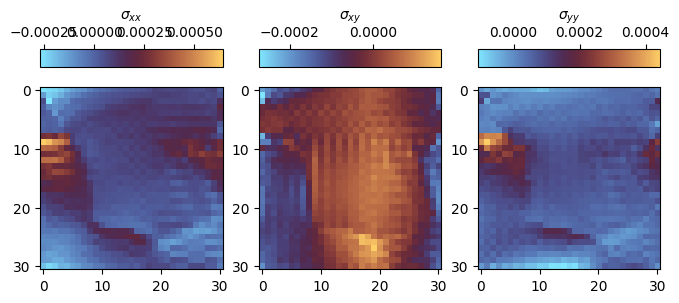

In [13]:
import matplotlib.pyplot as plt  # noqa: E402
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

cax1 = ax1.imshow(sig.at[:, :, int(N / 2), 0, 0].get(), cmap="managua_r")

divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cax1, cax=cax, label=r"$\sigma_{xx}$", orientation="horizontal", location="top")


cax2 = ax2.imshow(sig.at[:, :, int(N / 2), 0, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cax2, cax=cax, label=r"$\sigma_{xy}$", orientation="horizontal", location="top")

cax3 = ax3.imshow(sig.at[:, :, int(N / 2), 1, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cax3, cax=cax, label=r"$\sigma_{yy}$", orientation="horizontal", location="top")

plt.show()
